# Text Similarity
- There is always need to compute the similarity in meaning between texts.
    1. **Search Engines** need to model the relevance (appropriate) of a document to a query, beyond the overlap in words between the two.
        - For instance, **question-and-answer** sites such as Quora or stackoverflow need to determine whether a question has already been asked before.
    2. **In legal matters**, text similarity task allow to mitigate risks on a new contract, based on the assumption that if a new contract is similar to a existent one that has been proved to be resilient, the risk of this new contract being the cause of financial loss is minimised.
    3. **In customer services**, AI system should be able to understand semantically similar queries from users and provide a uniform response.
        - For example, if the user asks **What has happened to my delivery?** or **What is wrong with my shipping?**, the user will expect the same response.
- All the similarity measures map to the range of [-1, 1] or [0, 1]. The 0 or -1 represents minimal similarity, and 1 represents absolute similarity
- Text similarity has to determine how 'close' two piece of text are both in surface closeness (**lexical similarity**) and meaning (**semantic similarity**)
    - **lexical similarity** of 1 would mean a total overlap between vocabularies, whereas 0 means there are no common words.
    - **semantic similarity** between two text is based on the likeness of their meaning
- For instance, how similar are the phrases **the cat ate the mouse** with the **the mouse ate the cat food** by just looking at the words?
    - **On the surface**, if you consider only **word level similarity**, these two phrases appear very similar as 3 of the 4 unique words are an exact overlap. 
        - It typcally does not take into account the actual meaning behind words or the entire phrase in context.
    - Instead of doing a **word for word comparison**, we also need to pay attention to **context** in order to capture more of the **semantics**.
        - To consider **semantic similarity** we need to focus on **phrase/paragraph levels** (or lexical chain level) where piece of text is broken into a relevant group of related words prior to computing similarity. We know that while the words significantly overlap, these two phrases actually have different meaning
- There is a **dependency structure** in any sentences:
    > **mouse** is the object of **ate** in the first case and **food** is the object of **ate** in the second case
    - Since **differences in word order** often go hand in hand with **differences in meaning** (compare **the dog bites the man** with **the man bites the dog**), we'd like our sentence embeddings to be **sensitive to this variation**.
    

### Computing Text Similarity
- In this notebook we deal with mainly two types of text similarity measure,
   1. **Jaccard Similarity**
   2. **Cosine Similarity**
   

### Text Preprocessing
- Text preprocessing steps are very essential before we compute similarity scores using technique mentioned
- As we know text is represented as a vector in multidimension space. In vector space model each word/term is an axis or dimension, the number of unique words means the number of dimensions, hence text preprocessing should done before computing any similarity  measure
- **Following preprocessing techniques are applied:**
   1. **lower casing**
   2. **remove special symbols**
   3. **remove punctuation**
   4. **remove stopwords**
   5. **Lemmatization**

In [7]:
# import necssary packages
import spacy
import re
import pandas as pd
import numpy as np
from nltk.tokenize import word_tokenize

# load the english model and initialize an object called 'nlp'
nlp = spacy.load("en_core_web_sm")

# convert string into its lower case
def lower_casing(text):
    """
    Obtained the lower case version and passed lower case version of text 

    Arguments:
    text: raw text, strings

    Returns:
    lower_text: string, representing lower case of raw text
    """

    # lower casing
    lower_text = text.lower()

    return lower_text

# remove special symbols using regex
def remove_special_symbols(text):
    """
    remove specified symbols such as numbers, replace hyphen and dot with space in given text passed as an argument 
    
    Arguments: raw text, strings
    
    Returns: 
    processed_text = text obtained after preprocessing
    """
    
    # replace hyphen, dot with space
    text_with_no_hyphen = text.replace("-", " ").replace(".", " ")
    

    #specifying the things we want to remove using regular expressions and removing using sub
    regex_remove = "([0-9])|(@[A-Za-z0-9]+)|([^0-9A-Za-z t])|(w+://S+)|^RT|http.+?"
    
    clean_text = re.sub(regex_remove, '', text_with_no_hyphen).strip()
    clean_text = ''.join(clean_text)
    

    
    return clean_text
    
# remove punctuations
def remove_punctuation(text):
    """
    removes punctuation symbols present in the raw text passed as an arguments
    
    Arguments:
    text: raw text
    
    Returns: 
    not_punctuation: list of tokens without punctuation
    """
    # passing the text to nlp and initialize an object called 'doc'
    doc = nlp(text)
    
    not_punctuation = []
    # remove the puctuation
    for token in doc:
        if token.is_punct == False:
            not_punctuation.append(token)
    
    return not_punctuation


# tokenize words
def tokenize_word(text):
    """
    Tokenize the text passed as an arguments into a list of words(tokens)
    
    Arguments:
    text: raw text
    
    Returns:
    words: list containing tokens in text
    """
    # passing the text to nlp and initialize an object called 'doc'
    doc = nlp(text)
    
    # Tokenize the doc using token.text attribute
    words = [token.text for token in doc]
        
    # return list of tokens
    return words

# remove stopwords
def remove_stopwords(tokens):
    """
    Removes stopwords passed from the tokens list passed as an arguments
    
    Arguments:
    tokens: list of tokens
    
    Returns:
    tokens_without_sw: list of tokens of raw text without stopwords
    """
    
    # getting list of default stop words in spaCy english model
    stopwords =nlp.Defaults.stop_words
    
    # tokenize text
    text_tokens = tokens
    
    # remove stop words:
    tokens_without_sw = [word for word in text_tokens if word not in stopwords]
    
    # return list of tokens with no stop words
    return tokens_without_sw


# Lemmatization
def lemmatization(tokens):
    """
    obtain the lemma of the each token in the token list, append to the list, and returns the list
    
    Arguments:
    text: list of tokens
    
    Returns:
    lemma_list: return list of lemma corresponding to each tokens
    """
    

    lemma_list = []
    # Lemmatization
    for token in tokens:
        lemma_list.append(token.lemma_)
    
    return lemma_list

Now lets combine above defined different preprocessing steps into single module named **preprocess_text(text)** which will be used later to preprocess the document before calculating similarity score.

In [8]:
# raw text preprocessing
def preprocess_text(text):
    """
    - preprocess raw text passed as an arguments
    - preprocessing of text includes, lower_casing, remove_special_symbols, remove_punctuation, remove_stopwords, lemmatization
    
    Arguments: raw text, string
    
    Returns: list of tokens obtained after preprocessing
    """
    
    # lower casing
    lower_case_text = lower_casing(text)
    
    # remove special symbols
    removed_special_symbols = remove_special_symbols(lower_case_text)
    
    # remove punctuation
    tokens_without_punct = remove_punctuation(removed_special_symbols)
    
    # remove stopwords
    tokens_without_stopwords = remove_stopwords(tokens_without_punct)
    
    # lemmatization
    lemma_of_tokens = lemmatization(tokens_without_stopwords)

    # return preprocessed text
    return lemma_of_tokens

### Jaccard Similarity 
- Jaccard coefficient is used to compare the similarity and non-similarity of two documents based on the presence or absence of terms in documents.
- Jaccard similarity or intersection over union is defined as **size of intersection divided by size of union of two sets**.
- **Jaccard(A, B):**  _intersection(A, B)/union(A, B)_
- The **degree of similarity** is a value between 0 and 1.
   - If the **degree of similarity = 1** the two documents are same and identical.
   - If the **degree of similarity = 0** the two documents are completely dissimilar.

### Cosine Similarity
- Cosine similarity is a metric used to measure how similar the documents are irrespective of their size.
- Mathematically, it measures the **cosine of the angle** between two vectors project in multidimensional space.
- The cosine similarity is advantageous because even if the two similar documents are far apart by the Euclidean distance (due to the size of the document), chances are they may still oriented closer together. The small the angle, higher the cosine similarity.
- The **cosine similarity of A and B is defined as,**
    - **cos(A, B)** = _dot_product(A,B) / magnitude(A) * magnitude(B)_
- The **degree of similarity** is a value between -1 and 1.
    - If documents are similar, their vectors will be in the same direction from origin, thus, they form a relatively small angle, which its cosine value will be near 1.
    - On the other hand, when two vectors are different direction from origin, they form a wide angle and the value of the cosine is near to -1.
- **Important Property**
    - Easy to implement
    - Efficient to evaluate
    - it is independence from the length of documents.
    
Now, lets define the function for **jaccard_similarity(text1, text2)** and **cosine_similarity(df)** to calculate similarity score using two different technique

In [9]:
# calulate jaccard similarity
def jaccard_similarity(text1, text2):
    """
    calculate jaccard similarity index between two preprocessed tokenized list of text i.e. text1, text2
    jaccard index = size of intersection / size of union

    Arguments:
    text1: article or text which is preprocessed and contains list of tokens, (list of tokens)
    text2: article or text which is preprocesed and contains list of tokens, (list of tokens)
    
    Returns:
    jaccard_score: result of similarity between two text using jacard index
    """
    # intersection between two text i.e. text1, text2
    intersection = set(text1).intersection(set(text2))
    
    # union between two text i.e. text1, text2
    union = set(text1).union(set(text2))    
    
    # calculate jaccard score
    jaccard_score = len(intersection)/len(union)
    

    return jaccard_score

As we have written module that computes **jaccard similarity** between two documents

Now lets, move towards **cosine similarity**

#### Term Document  Matrix
- **Term Document Matrix** contains frequency of words for each documents represented using pandas dataframe
- **Why term document matrix?**
     - Text data are considered to be an unstructured data, which does not have a specific format and cannot be analyzed on its own. 
     - The text data has has to be converted into a structured format for further analysis.
     - To form this conversion **term document matrix** is deployed.
- **Term Document Matrix** is a two dimension matrix which its columns corresponds to documents, and its rows correspond to terms. The value of each cell is the term frequency of a word in a particular document.

#### Comparison between Term Document Matrix and Jaccard 
- The total number of rows in **Term Document Matrix** which represents the terms available in both documents are considered as the **union of two documents** in Jaccard Similarity .
- Likewise, the total number of words that are remained after eliminating the terms that are having value zero in any of two documents returns the **intersection of two documents**.

Now, let's **obtain the term document** matrix and using **pandas dataframe** and use it compute **cosine similarity** between the two documents.

In [10]:
def obtain_term_document(text1, text2):
    """
    Takes two preprocessed tokenized text i.e. text1 and text2 and calculate the term in each documents and return
    pandas dataframe representing frequency of union of words in text1 and text2 for each documents i.e. text1 and text2
    in normalized form
    
    Arguments:
    text1: Preprocessed tokenized text or documents, list of tokens
    text2: Preprocessed tokenized text or documents, list of tokens
    
    Returns:
    df: pandas dataframe containing frequency of word terms for each documents in normalize form
    """
    # union of word tokens in text1 and text2
    union_of_words = set(text1).union(set(text2))
    
    word_count_text1 = [] #initialeze for sotring frequency of words
    word_count_text2 = [] #initialize for storing frequency of words
    
    # word frequency count for each text
    for word in union_of_words:
        word_count_text1.append(text1.count(word))
        word_count_text2.append(text2.count(word))
    
    # create dataframe containing frequency of words for each text i.e. text1 and text2
    df = pd.DataFrame(list(zip(word_count_text1, word_count_text2)), index=union_of_words, columns=['text1', 'text2'])
    
    # normalize each text
    df["text1"] = round(df["text1"]/df["text1"].sum(), 3)
    df["text2"] = round(df["text2"]/df["text2"].sum(), 3)
    
    return df

def cosine_similarity(dataframe):
    """
    computes cosine of the angle between two vectors and helps us to find out how related two documents are
    
    Arguments:
    dataframe: dataframe containing normalized terms/words in each document
    
    Returns:
    cosine_similarity_score: cosine_similarity_score between two documents
    """
    # convert each column of dataframe which represent individual documents into array
    document_one_vector = np.array(df.iloc[:, 0]) # vector representing document1 or text1
    document_two_vector = np.array(df.iloc[:, 1]) # vector representing document2 or text2
    
    # calulate dot product of the two vector
    dot_product_of_two_vector = np.dot(document_one_vector, document_two_vector)
    
    # calculate magnitude for each vector
    document_one_vector_magnitude = np.sqrt(np.sum(np.square(document_one_vector))) # magnitude for vector document1
    document_two_vector_magnitude = np.sqrt(np.sum(np.square(document_two_vector))) # magnitude for vector document2
    
    # compute cosine similarity for two documents
    cosine_similarity_score = dot_product_of_two_vector/(document_one_vector_magnitude*document_two_vector_magnitude)
    
    return cosine_similarity_score

Finally necessary steps for two similarity measure technique i.e. **jaccard_similarity** and **cosine_similarity** is completed.  

Now, lets use all the defined modules, staring from **text preprocessing** to **cosine_similarity** to calculate the **similarity score** between two documents.

,similarity_score
jaccard_similarity,0.288462
cosine_similarity,0.593076


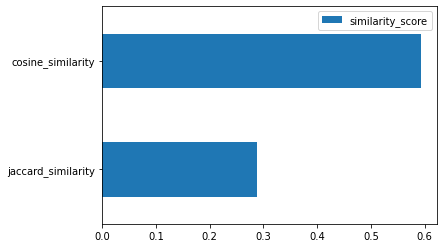

In [13]:
# sample article 1
article_1 = """Nepal on Thursday reported 12 more Covid-19-related fatalities, pushing the death toll to 1,663. 
The country also recorded 1,217 new cases.The overall infection tally has reached 245,650 with 12,386 active cases.
According to the Ministry of Health and Population, 231,601 infected people have recovered from the disease so far; 
1,064 of them in the past 24 hours."""

# sample article 2
article_2 = """As of Thursday, the number of confirmed cases in the Valley has reached 114,409 While Kathmandu has
reported 432 Covid-19-related fatalities so far, Lalitpur and Bhaktapur have recorded 129 and 97 deaths respectively."""

# sample article 3
article_3 = """The Johns Hopkins University data dashboard reported 3,124 deaths, breaking a record of 2,885 set 
just last week. New infections are also booming, and across the nation hospitals are running out of beds, prompting stay-at-home orders in some places and mask mandates in 38 states."""

# preprocess the text
preprocessed_article_1 = [item for item in preprocess_text(article_1) if item not in [' ', '  ']]
preprocessed_article_2 = [item for item in preprocess_text(article_2) if item not in [' ', '  ']]

# compute jaccard similarity socre
jaccard_similarity_score = jaccard_similarity(preprocessed_article_1, preprocessed_article_2)

# compute cosine similarity score
df = obtain_term_document(preprocessed_article_1, preprocessed_article_2)
cosine_similarity_score = cosine_similarity(df)

# add jaccard_similarity_score and cosine_similarity_score to dataframe
data = {'similarity_score':[jaccard_similarity_score, cosine_similarity_score]}
similarity_score = pd.DataFrame(data, index = ['jaccard_similarity', 'cosine_similarity'])

# plot similarity score
similarity_score.plot(kind="barh")

# similarity score represented using pandas dataframe
similarity_score

- As we can see we have obtained the **jaccard_similarity_score** and **cosine_similarity_score** for two news article 
- According to **jaccard_similarity_score** the text are not quite similar, with **similarity_score=0.288462**
- According to **cosine_similarity_score** the text are more  similar as compared to **jaccard_similarity_score**, with **similarity_score=0.593076**
- Actually, two text are a bit similar as both are talking about _covid-19_, so **cosine_similarity** is able to give the better **similarity score.**

### Conclusion
- We discussed importance of text similarity and two methods in computing similarity score between two documents.
- Text similarity measures are very important concepts in text mining and information retrieval that helps to quantify similarity between documents, which is effective in improving the performance of search engines and browsing techniques.
- Similarity measurement are widely used in applications such as **duplicate detection**, **automatic scoring**, **topic detection**, **document clustering**, **text classification.**
- All the similarity measures map to the range of [-1, 1] or [0, 1]. The 0 or -1 represents minimal similarity, and 1 represents absolute similarity.
- The big idea of calculating similarity is that **documents is represented as vectors of features**, and **compare documents by measuring the distance between these features.**
- Before computing **similarity score** between two texts or documents, they are **preprocessed** using technique mentioned below in order:
   - **lower casing**
   - **remove special symbols**
   - **remove punctuation**
   - **remove stopwords**
   - **Lemmatization**
- Here **jaccard similarity** and **cosine similarity** are used to compute the similarity score between two text or documents.
- **jaccard similarity** computes the similarity score by **size of intersection divided by size of union of two sets of words**
- **Cosine similarity** measures the **cosine of the angle** between two vectors projected in multidimensional space using formulae
   - **cos(A, B)** = _dot_product(A,B) / magnitude(A) * magnitude(B)_
- Jaccard similarity may be inefficient if:
   - two similar documents are small, so that there may not be common words leading to least similar score
   - the size of the document increases, the number of common words tend to increase even if the documents talk about different topics i.e. **dissimilar documents**
- **advantage of cosine similarity**
   - cosine similarity measures text similarity by projecting documents in space, and calculating cosine angle between them.
   - These approach is independent from the length of documents, which result better similarity scores.
- **Future work**
   - Research on other different similarity measures such as:
      - **Soft Cosine Similarity**
      - **knowledge-based measures and so on**
   - Focus on more convinient and better way to preprocess the textual data by minimizing loss of information

### References:
- https://medium.com/@adriensieg/text-similarities-da019229c894
- http://article.nadiapub.com/IJDTA/vol10_no2/2.pdf
- https://www.machinelearningplus.com/nlp/cosine-similarity/
- https://github.com/makcedward/nlp/blob/master/sample/nlp-3_basic_distance_measurement_in_text_mining.ipynb